## Resource accounting
We will analyze how the Transformer and its blocks consume memory and compute: we first count the number of parameters in a given Transformers, see how it reflects in terms of memory consumptions, and then account the total number of floating-point operations (FLOPs) occuring during a forward-pass.

<p align="center">
      <td align="center"><img src="../illus/tiny_llama_bg.png" width="500"/></td>
</p>

## 1- Parameters & memory accounting

With $V$ the vocabulary size,

**Embedding**: &nbsp;&nbsp; $d_\mathrm{model} \cdot V$

**RMS Norm**: &nbsp;&nbsp; $d_\mathrm{model}$ 

**Multihead Self-Attention**: &nbsp;&nbsp; $n_\mathrm{heads} \cdot (3 \cdot d_\mathrm{head} \cdot d_\mathrm{model}) + d^2_\mathrm{model}$

**SwiGLU**: &nbsp;&nbsp; $3 \cdot d_\mathrm{model} d_{ff}$

**Output linear**: $d_\mathrm{model} \cdot V$

> **Total number of parameters $P$ in a LLaMA-like transformer**:
> $$ P = (2 V + 1) d_\mathrm{model} + n_\mathrm{layers} \Big(4 d^2_\mathrm{model} + (3 d_{ff} + 2) d_\mathrm{model} \Big) $$

In naïve FP32 representation, this Transformer architecture therefore consumes over **4 P** bytes of memory just to store it in GPU !

Let's test this out on a small Tiny-LLaMA model:

In [22]:
from tiny_llama.transformer import TransformerLM

V = 10_000
d_model = 512
n_layers = 4
d_ff = 1344

model = TransformerLM(vocab_size=V,
                      context_length=256,
                      num_layers=n_layers,
                      d_model=d_model,
                      num_heads=16,
                      d_ff=d_ff,
                      theta=10_000)

nb_params = (2*V + 1) * d_model + n_layers * (4*d_model**2 + (3*d_ff + 2)*d_model)
assert sum(p.numel() for p in model.parameters()) == nb_params

print(f"Calculated number of parameters: {nb_params} (with {nb_params - (d_model*V)} non-embedding parameters).")
print(f"In fp32, this will cost approx. {(4 * nb_params / 1e6):.2f} Mb to store in memory.")


Calculated number of parameters: 22696448 (with 17576448 non-embedding parameters).
In fp32, this will cost approx. 90.79 Mb to store in memory.


Now, let's see what happens with a larger GPT-2-XL model:

In [30]:
V = 50_257
d_model = 1600
n_layers = 48
n_heads = 25
d_ff = 6400

gpt_2_xl_params = (2*V + 1) * d_model + n_layers * (4*d_model**2 + (3*d_ff + 2)*d_model)

print(f"GPT-2-XL contains {gpt_2_xl_params} parameters.")
print(f"In fp32, this will cost approx. {(4 * gpt_2_xl_params / 1e9):.2f} Gb to store in memory.")

GPT-2-XL contains 2127057600 parameters.
In fp32, this will cost approx. 8.51 Gb to store in memory.


Or huge-scale orders of magnitudes (e.g. [LLaMA-3, 2024](https://arxiv.org/pdf/2407.21783)):

In [40]:
V = 128_000
d_model = 16_384
n_layers = 126
n_heads = 128
d_ff = 53_248

huge_model_params = (2*V + 1) * d_model + n_layers * (4*d_model**2 + (3*d_ff + 2)*d_model)

print(f"This huge model would contain {huge_model_params} parameters.")
print(f"In fp32, this would cost approx. {(4 * huge_model_params / 1e9):.2f} Gb to store in memory.")
print(f"In fp16, this would cost approx. {(2 * huge_model_params / 1e9):.2f} Gb to store in memory.")

This huge model would contain 469262876672 parameters.
In fp32, this would cost approx. 1877.05 Gb to store in memory.
In fp16, this would cost approx. 938.53 Gb to store in memory.


## 2- FLOPs accounting

The total number of FLOPs in a Transformer model is largely dominated by the matrix multiplications inside transformer layers, in the MHA and FFN sub-layers.
We will compute a lower bound on the number of FLOPs during a forward pass (neglecting the less costly operations)

#### FLOPs in a Transformer layer:

We consider an input $x \in \mathbb{R}^{B \times S \times d_\mathrm{model}}$.

>**RMS Norm** : &nbsp;&nbsp; $4 \cdot B \cdot S \cdot d_\mathrm{model} + \mathrm{cst}$

**Computing Queries, Keys and Values** : &nbsp;&nbsp; $6 \cdot B \cdot S \cdot d^2_\mathrm{model}$

**Computing $Q K^\top$ for all heads** : &nbsp;&nbsp; $2 \cdot B \cdot S^2 \cdot d_\mathrm{model}$

**Applying $V$ for all heads** : &nbsp;&nbsp; $2 \cdot B \cdot S^2 \cdot d_\mathrm{model}$

**Applying the output projection**: &nbsp;&nbsp; $2 \cdot B \cdot S \cdot d^2_\mathrm{model}$

> **Total FLOPs for the Multihead Self-Attention in a layer (neglecting softmax overhead)**:
> $$ \mathrm{FLOPs}^{\mathrm{MHSA}} \approx 8 B S d^2_\mathrm{model} + 4 B S^2 d_{\mathrm{model}} $$

> **Total FLOPs for the SwiGLU in a layer**:
> $$ \mathrm{FLOPs}^{\mathrm{SwiGLU}} \approx 6 B S \left(d_\mathrm{model} d_{ff} + d_{ff} \right) $$

> **Total FLOPs for a single Transformer layer**:
> $$ \mathrm{FLOPs}^{\mathrm{layer}} \approx \underbrace{8 B S d_\mathrm{model}}_{\text{RMS Norms}} + 
                                        \underbrace{8 B S d^2_\mathrm{model} + 4 B S^2 d_{\mathrm{model}}}_{\text{MHSA}} +
                                        \underbrace{6 B S \left(d_\mathrm{model} d_{ff} + d_{ff} \right)}_{\text{SwiGLU}} +
                                        \underbrace{B S d_\mathrm{model}}_{\text{Res. connections}} $$

Let's see which blocks constitute bottlenecks in a single Transformer layer:

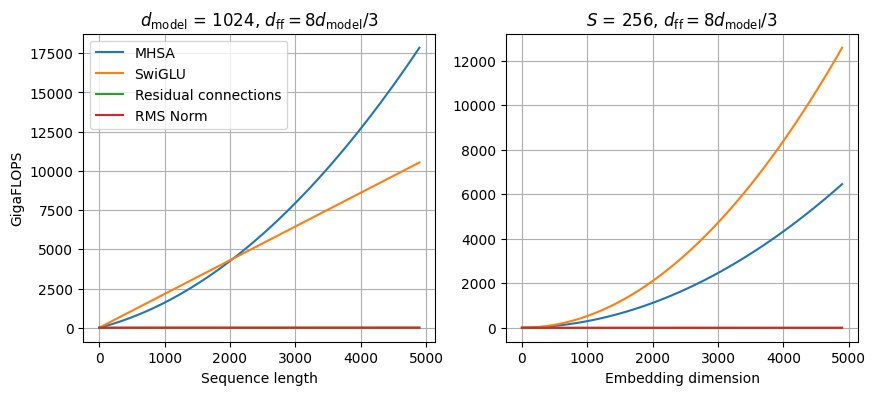

In [107]:
import numpy as np 
import matplotlib.pyplot as plt

B = 128 # batch_size
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Influence of sequence length
S = np.arange(5000, step=100) # seq_len
d_model = 1024
d_ff = 8*d_model/3
flops_rms = 8*B*S*d_model 
flops_mhsa = 8*B*S*d_model**2 + 4*B*d_model*S**2
flops_swiglu = 6*B*S*(d_model*d_ff + d_ff)
flops_res_co = B*S*d_model
ax[0].plot(S, flops_mhsa / 1e9, label="MHSA")
ax[0].plot(S, flops_swiglu / 1e9, label="SwiGLU")
ax[0].plot(S, flops_res_co / 1e9, label="Residual connections")
ax[0].plot(S, flops_rms / 1e9, label="RMS Norm")
ax[0].legend()
ax[0].set_title(f"$d_\mathrm{{model}}$ = {d_model}, $d_\mathrm{{ff}} = 8 d_\mathrm{{model}} /3$")
ax[0].grid(which="both")
ax[0].set_xlabel("Sequence length")
ax[0].set_ylabel("GigaFLOPS")

# Influence of d_model
S = 256 # seq_len
d_model = np.arange(5000, step=100)
d_ff = 8*d_model/3
flops_rms = 8*B*S*d_model 
flops_mhsa = 8*B*S*d_model**2 + 4*B*d_model*S**2
flops_swiglu = 6*B*S*(d_model*d_ff + d_ff)
flops_res_co = B*S*d_model
ax[1].plot(d_model, flops_mhsa / 1e9, label="MHSA")
ax[1].plot(d_model, flops_swiglu / 1e9, label="SwiGLU")
ax[1].plot(d_model, flops_res_co / 1e9, label="Residual connections")
ax[1].plot(d_model, flops_rms / 1e9, label="RMS Norm")
ax[1].grid(which="both")
ax[1].set_xlabel("Embedding dimension")
ax[1].set_title(f"$S$ = {S}, $d_\mathrm{{ff}} = 8 d_\mathrm{{model}} /3$")

plt.show()
